# Toxic comment classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import nltk
from nltk.corpus import stopwords

from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Carga de datasets

In [3]:
# Dataset train
df_train = pd.read_csv('/content/gdrive/MyDrive/datos/jigsaw-toxic-comment-classification-challenge/train.csv')
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
# Dataset test
df_test = pd.read_csv('/content/gdrive/MyDrive/datos/jigsaw-toxic-comment-classification-challenge/test.csv')
df_test_labels = pd.read_csv('/content/gdrive/MyDrive/datos/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

In [5]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [6]:
df_test_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [7]:
# Replace -1 for 1
df_test_labels = df_test_labels.replace(-1, 1)

In [8]:
# Join data test with labels
df_test = df_test.merge(df_test_labels, how='inner', on='id')
df_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,1,1,1,1,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,1,1,1,1,1,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",1,1,1,1,1,1
3,00017563c3f7919a,":If you have a look back at the source, the in...",1,1,1,1,1,1
4,00017695ad8997eb,I don't anonymously edit articles at all.,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",1,1,1,1,1,1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,1,1,1,1,1,1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",1,1,1,1,1,1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",1,1,1,1,1,1


In [9]:
df = df_train

## Data Exploratory Analysis

In [10]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

### Labels distribution

[Text(0.5, 1.0, 'Toxic comments distribution')]

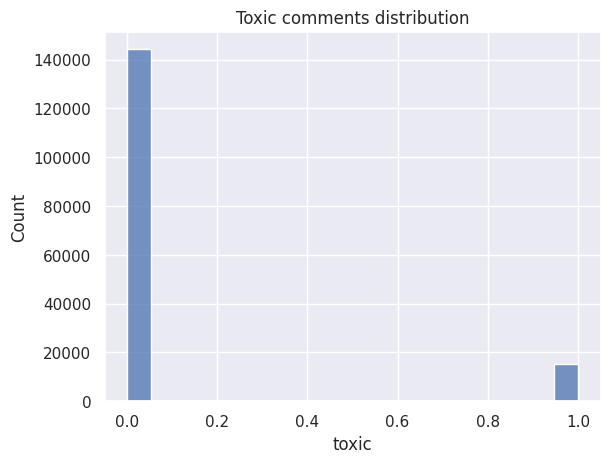

In [11]:
sns.histplot(data=df, x="toxic").set(title='Toxic comments distribution')

[Text(0.5, 1.0, 'Severe toxic comments distribution')]

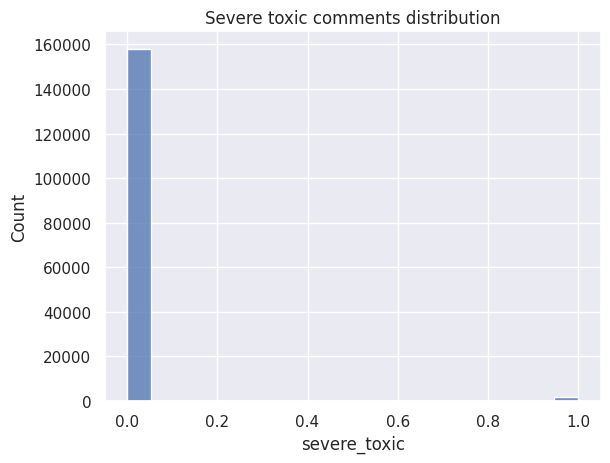

In [12]:
sns.histplot(data=df, x="severe_toxic").set(title='Severe toxic comments distribution')

[Text(0.5, 1.0, 'Obscene comments distribution')]

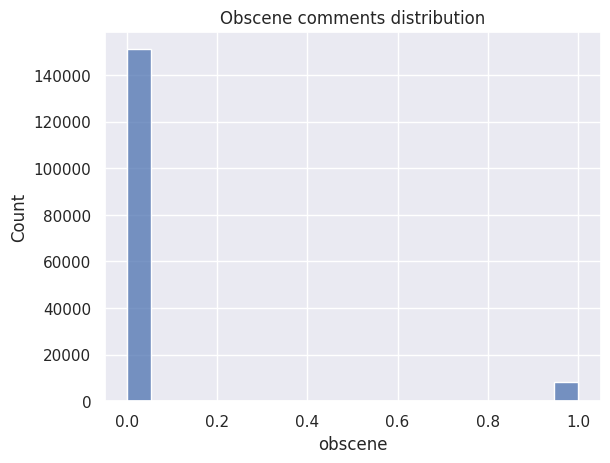

In [13]:
sns.histplot(data=df, x="obscene").set(title='Obscene comments distribution')

[Text(0.5, 1.0, 'Threat comments distribution')]

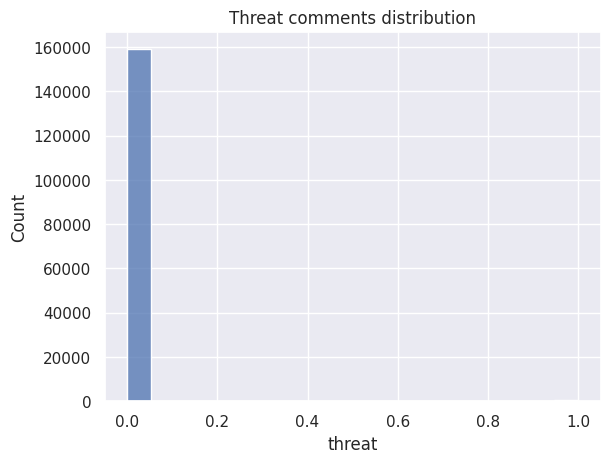

In [14]:
sns.histplot(data=df, x="threat").set(title='Threat comments distribution')

[Text(0.5, 1.0, 'Insult comments distribution')]

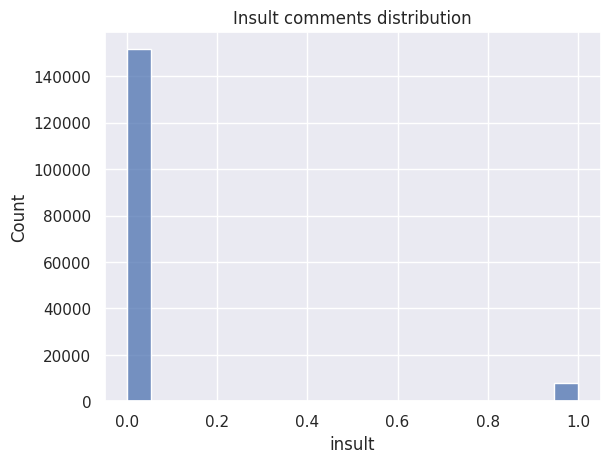

In [15]:
sns.histplot(data=df, x="insult").set(title='Insult comments distribution')

[Text(0.5, 1.0, 'Identity hate comments distribution')]

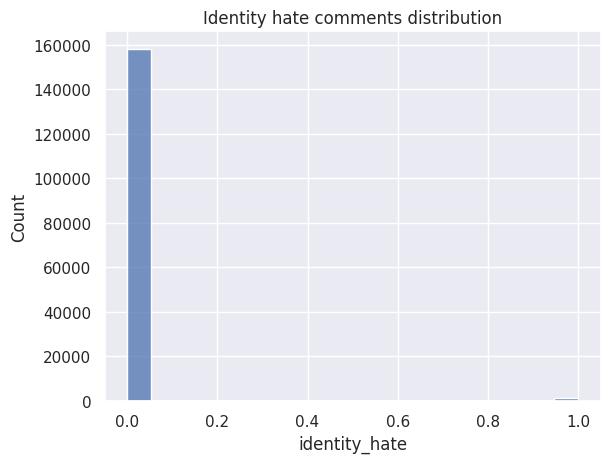

In [16]:
sns.histplot(data=df, x="identity_hate").set(title='Identity hate comments distribution')


The dataset is unbalanced for all labels.

### Text length distribution


In [17]:
# Calculate the comments length
df['comment_len'] = df['comment_text'].apply(lambda text: len(text))

df_test['comment_len'] = df_test['comment_text'].apply(lambda text: len(text))

In [18]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [19]:
df['comment_len'].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_len, dtype: float64

[Text(0.5, 1.0, 'Comments length distribution')]

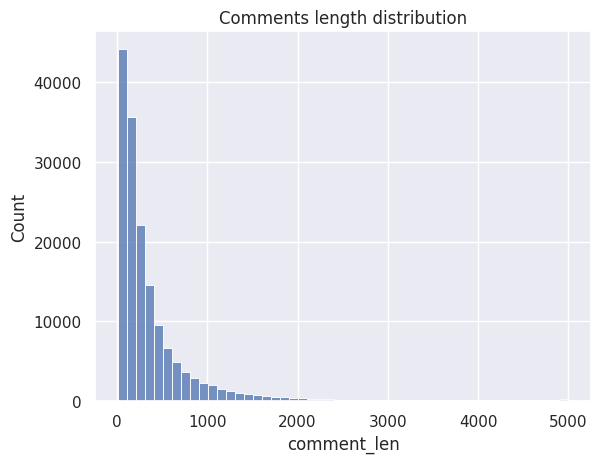

In [20]:
sns.histplot(data=df, x="comment_len", bins=50).set(title='Comments length distribution')

Most comments have a length between 0 and 143 characters.

### Feature Engineering

In [21]:
import re

In [22]:
# Function to calculate the number of symbols in a comment
def count_symbols(comment):
    non_letters_spaces_numbers = re.findall(r'[^a-zA-Z\s\d]', comment)
    count = len(non_letters_spaces_numbers)
    return count

# Function to calculate the number of capital letters in a comment
def count_capital_letters(comment):
    count = sum(1 for char in comment if char.isupper())
    return count

# Function to calculate the number of exclamation marks in a comment
def count_exclamation_marks(comment):
  return comment.count('!')

# Function to calculate the number of question marks in a comment
def count_question_marks(comment):
  return comment.count('?')

# Function to calculate the number of words in a comment
def count_words(comment):
    words = comment.split()
    return len(words)

# Function to create the number of symbols, number of capital letters, number of exclamation points and question features in a dataframe
def create_features(df):
  df['symbols'] = df['comment_text'].apply(lambda comment: count_symbols(comment))
  df['capital_letters'] = df['comment_text'].apply(lambda comment: count_capital_letters(comment))
  df['exclamation'] = df['comment_text'].apply(lambda comment: count_exclamation_marks(comment))
  df['question'] = df['comment_text'].apply(lambda comment: count_question_marks(comment))

In [23]:
# Create the features in the train and test dataframes
create_features(df)
create_features(df_test)

In [24]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,10,17,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,12,8,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,6,4,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,21,11,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,5,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295,18,2,0,2
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99,4,2,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81,4,4,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116,1,2,0,0


In [25]:
df_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,1,1,1,1,1,367,12,4,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,1,1,1,1,1,1,50,6,7,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",1,1,1,1,1,1,54,9,4,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",1,1,1,1,1,1,205,6,4,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,1,1,1,1,1,1,41,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",1,1,1,1,1,1,60,4,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,1,1,1,1,1,1,198,7,5,0,2
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",1,1,1,1,1,1,423,36,15,0,1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",1,1,1,1,1,1,502,33,23,0,1


### Text preprocessing

In [26]:
# Imports
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string

In [27]:
# Download libraries
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [28]:
# Stopwords list
stop_words = set(stopwords.words('english'))

# Months list
months = [
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december'
]
months_set = set(months)

In [29]:
# Functions for the comments preprocessing

# Function to remove links from comments
def remove_links(text):
    pattern = r'(https?://\S+)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

# Function to remove contractions from comments
def remove_contractions(text):
    cleaned_text = text.replace('\n', ' ')
    cleaned_text = cleaned_text.replace("can't", 'can not')
    cleaned_text = cleaned_text.replace("n't", ' not')
    cleaned_text = cleaned_text.replace("'m", ' am')
    cleaned_text = cleaned_text.replace("'s", ' is')
    cleaned_text = cleaned_text.replace("'re", ' are')
    cleaned_text = cleaned_text.replace("'ve", ' have')
    cleaned_text = cleaned_text.replace("'d", ' did')
    cleaned_text = cleaned_text.replace("'ll", ' will')

    return cleaned_text

# Function to remove symbols from comments
def remove_symbols(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return cleaned_text

# Function to remove stopwords from comments
def remove_stopwords(text):
    filtered_sentence = ''

    for word in word_tokenize(text):
        if not word in stop_words and not word in months_set:
            filtered_sentence += word
            filtered_sentence += ' '

    return filtered_sentence

# Function to remove repeated words from comments
def remove_repeated_text(comment):
    # Define the pattern to match repeated words
    pattern = r'\b(\w+)\b\s+(?=.*\b\1\b)'

    # Remove repeated text using the pattern
    cleaned_comment = re.sub(pattern, '', comment)

    return cleaned_comment

# Function to lemmatize text from comments
def lemma(text, lemmatizer):
    output=""
    words = text.split(" ")
    for word in words:
        w1 = lemmatizer.lemmatize(word, pos = "n")
        w2 = lemmatizer.lemmatize(w1, pos = "v")
        w3 = lemmatizer.lemmatize(w2, pos = "a")
        w4 = lemmatizer.lemmatize(w3, pos = "r")
        output = output + " " + w4

    return str(output.strip())

# Function to remove words with more thant 13 characters from comments
def remove_long_words(comment):
    pattern = r'\b\w{13,}\b'

    # Remove long words using the pattern
    cleaned_text = re.sub(pattern, '', comment)

    return cleaned_text

# Function to preprocess text from comments
def preprocess_text(text, lemmatizer):
    text_lowercase = text.lower()
    cleaned_text = remove_links(text_lowercase)
    cleaned_text = remove_contractions(cleaned_text)
    cleaned_text = remove_symbols(cleaned_text)
    cleaned_without_stopwords = remove_stopwords(cleaned_text)
    cleaned_text = remove_long_words(cleaned_without_stopwords)
    cleaned_text = remove_repeated_text(cleaned_text)
    cleaned_lemmas = lemma(cleaned_text, lemmatizer)
    return cleaned_lemmas

In [30]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

In [31]:
# Calculate the preprocessing text from train and test comments
df['cleaned_text'] = df['comment_text'].apply(lambda text: preprocess_text(text, lemmatizer))
df_test['cleaned_text'] = df_test['comment_text'].apply(lambda text: preprocess_text(text, lemmatizer))

### Feature Engineering on preprocessed text

In [32]:
# Swear words list
swear_words = ['arse', 'arsehead', 'arsehole', 'arseholic', 'ass', 'asshole', 'assholic', 'bastard', 'bitch', 'bloody', 'bollocks', 'brotherfucker', 'bugger', 'bullshit',
               'christ', 'cock', 'cocksucker', 'crap', 'cunt', 'damn', 'dick', 'dickhead', 'dyke', 'fatherfucker', 'frigger', 'fuck', 'goddamn',
               'godsdamn', 'hell', 'shit', 'horseshit', 'jesus', 'jesuschrist', 'kike', 'motherfucker', 'piss', 'prick', 'pussy',
               'shite', 'sisterfucker', 'slut', 'whore', 'spastic', 'turd', 'twat', 'wanker', 'faggot', 'ball', 'aids', 'cow', 'sod', 'bint',
               'munter', 'minger', 'bellend', 'tit', 'gash', 'knob', 'rubish', 'fanny', 'hole', 'minger', 'gash', 'twat', 'punami', 'flaps', 'beaver',
               'wtf', 'bamf', 'fml', 'gtfo', 'pita', 'stfu', 'pdq', 'fubar', 'snafu', 'dafuq', 'effing', 'mofo', 'fuxache', 'fyvm', 'nfg', 'rape', 'sucker',
               'fucker', 'cocker', 'stink', 'lick', 'anus', 'fuckhead', 'stupid', 'fool', 'idiot']

# Identity hate speach words
hate_speach = ['gay', 'lesbian', 'semite', 'jew', 'nazi', 'holocaust', 'nigger', 'fagget', 'nigga', 'nigra', 'faggoty', 'fag']

# Function to count the number of swear words from comments
def count_swear_words(comment):
  count = 0
  for word in comment.split():
    if word in swear_words:
      count += 1

  return count

# Function to count the number of identity hate speach words from comments
def count_hate_speach_words(comment):
  count = 0
  for word in comment.split():
    if word in hate_speach:
      count += 1

  return count

# Function to count the number of words, number of characters, number of swear words and number identity hate speach words from comments
def create_features_cleaned(df):
  df['cleaned_len'] = df['cleaned_text'].apply(lambda text: len(text))
  df['cant_words'] = df['cleaned_text'].apply(lambda text: count_words(text))
  df['swear_words'] = df['cleaned_text'].apply(lambda text: count_swear_words(text))
  df['hate_speach'] = df['cleaned_text'].apply(lambda text: count_hate_speach_words(text))

In [33]:
# Calculate the features on the preprocessed text in the train and test dataset
create_features_cleaned(df)
create_features_cleaned(df_test)

In [34]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_text,cleaned_len,cant_words,swear_words,hate_speach
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,10,17,0,1,explanation edit make username hardcore metall...,151,23,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,12,8,1,0,aww match background colour seemingly stick th...,58,9,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,6,4,0,0,hey man really try edit war guy constantly rem...,127,21,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,21,11,0,0,make real suggestion improvement wonder sectio...,320,47,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,5,2,0,1,sir hero chance remember page,29,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295,18,2,0,2,second time ask view completely contradict cov...,158,22,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99,4,2,0,0,ashamed horrible thing put talk page,36,6,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81,4,4,0,0,spitzer umm there actual article prostitution ...,65,9,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,116,1,2,0,0,look like actually put speedy first version de...,55,9,0,0


In [35]:
df['cleaned_len'].describe()

count    159571.000000
mean        179.063483
std         233.815358
min           0.000000
25%          49.000000
50%         104.000000
75%         212.000000
max        2691.000000
Name: cleaned_len, dtype: float64

[Text(0.5, 1.0, 'Preprocessed comments length distribution')]

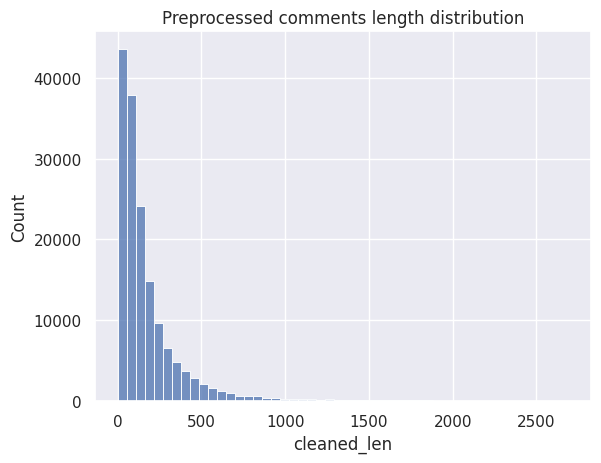

In [36]:
sns.histplot(data=df, x="cleaned_len", bins=50).set(title='Preprocessed comments length distribution')

In [37]:
# Number of comments with empty preprocessed text
len(df[df['cleaned_len']==0])

212

In [38]:
# Rows with unique cleaned text
df['cleaned_text'].nunique()

156779

In [39]:
# Remove rows with duplicated cleaned text, let the first appearance
df = df.drop_duplicates(subset=['cleaned_text'])

In [40]:
df['cant_words'].describe()

count    156779.000000
mean         26.850452
std          33.731819
min           0.000000
25%           8.000000
50%          16.000000
75%          32.000000
max         383.000000
Name: cant_words, dtype: float64

[Text(0.5, 1.0, 'Word count distribution of preprocessed comments')]

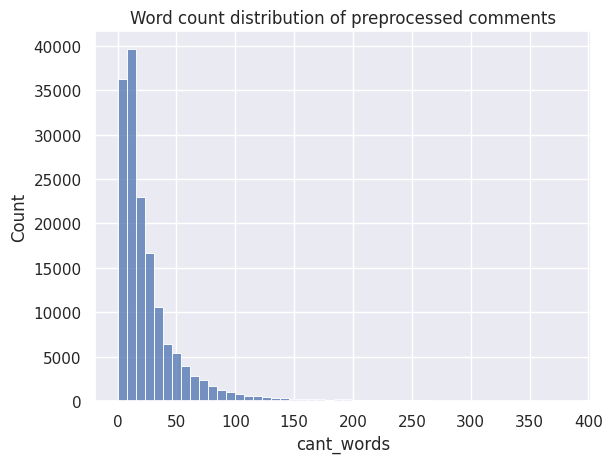

In [41]:
sns.histplot(data=df, x="cant_words", bins=50).set(title='Word count distribution of preprocessed comments')

In [42]:
len(df[df['cant_words']<=32])

118733

75% of the comments have 32 or fewer words. It is decided to take this number of maximum words per comment for training.

### Correlation analysis between numerical features and targets

In [43]:
df_features = df.drop(['id', 'comment_text', 'cleaned_text'], axis=1)

In [44]:
# Correlation matrix between the toxic label and the rest of features and labels
correlation_matrix = df_features.corr()['toxic']
print(correlation_matrix)

toxic              1.000000
severe_toxic       0.305701
obscene            0.674391
threat             0.155807
insult             0.645928
identity_hate      0.265560
comment_len       -0.058365
symbols           -0.018496
capital_letters    0.087730
exclamation        0.035195
question           0.026926
cleaned_len       -0.095996
cant_words        -0.087571
swear_words        0.538566
hate_speach        0.141182
Name: toxic, dtype: float64


In [ ]:
# Correlation matrix between the severe toxic label and the rest of features and labels
correlation_matrix = df_features.corr()['severe_toxic']
print(correlation_matrix)

toxic              0.305701
severe_toxic       1.000000
obscene            0.400180
threat             0.126573
insult             0.373301
identity_hate      0.203848
comment_len        0.005816
symbols            0.031117
capital_letters    0.136813
exclamation        0.055021
question          -0.005008
cleaned_len       -0.043948
cant_words        -0.040458
swear_words        0.359873
hate_speach        0.077317
Name: severe_toxic, dtype: float64


In [ ]:
# Correlation matrix between the obscene label and the rest of features and labels
correlation_matrix = df_features.corr()['obscene']
print(correlation_matrix)

toxic              0.674391
severe_toxic       0.400180
obscene            1.000000
threat             0.144257
insult             0.740034
identity_hate      0.287989
comment_len       -0.046608
symbols           -0.018821
capital_letters    0.076227
exclamation        0.021399
question           0.002325
cleaned_len       -0.078530
cant_words        -0.070995
swear_words        0.611042
hate_speach        0.111830
Name: obscene, dtype: float64


In [ ]:
# Correlation matrix between the threat label and the rest of features and labels
correlation_matrix = df_features.corr()['threat']
print(correlation_matrix)

toxic              0.155807
severe_toxic       0.126573
obscene            0.144257
threat             1.000000
insult             0.151020
identity_hate      0.117721
comment_len       -0.007356
symbols            0.018652
capital_letters    0.035621
exclamation        0.035131
question          -0.003727
cleaned_len       -0.020310
cant_words        -0.017656
swear_words        0.120166
hate_speach        0.036143
Name: threat, dtype: float64


In [ ]:
# Correlation matrix between the insult label and the rest of features and labels
correlation_matrix = df_features.corr()['insult']
print(correlation_matrix)

toxic              0.645928
severe_toxic       0.373301
obscene            0.740034
threat             0.151020
insult             1.000000
identity_hate      0.338095
comment_len       -0.048747
symbols           -0.021068
capital_letters    0.070668
exclamation        0.023822
question           0.002134
cleaned_len       -0.078112
cant_words        -0.071396
swear_words        0.538423
hate_speach        0.127464
Name: insult, dtype: float64


In [ ]:
# Correlation matrix between the identity hate label and the rest of features and labels
correlation_matrix = df_features.corr()['identity_hate']
print(correlation_matrix)

toxic              0.265560
severe_toxic       0.203848
obscene            0.287989
threat             0.117721
insult             0.338095
identity_hate      1.000000
comment_len       -0.013966
symbols           -0.010563
capital_letters    0.053783
exclamation        0.006229
question          -0.000292
cleaned_len       -0.030537
cant_words        -0.027154
swear_words        0.217549
hate_speach        0.280939
Name: identity_hate, dtype: float64


In general, a high correlation is observed between the labels. Some labels correlate to features, but it doesn't seem to be very critical.

### Features normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
features_list = ['comment_len', 'symbols', 'capital_letters', 'exclamation', 'question', 'cleaned_len', 'cant_words', 'swear_words', 'hate_speach']

# MinMaxScaler normalization
df[features_list] = scaler.fit_transform(df[features_list])
df_test[features_list] = scaler.transform(df_test[features_list])

<ipython-input-52-f6a0bc57c68d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features_list] = scaler.fit_transform(df[features_list])


In [ ]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_text,cleaned_len,cant_words,swear_words,hate_speach
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.051662,0.002023,0.003427,0.000000,0.004785,explanation edit make username hardcore metall...,0.056113,0.060052,0.0,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.021225,0.002428,0.001613,0.000202,0.000000,aww match background colour seemingly stick th...,0.021553,0.023499,0.0,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0.045455,0.001214,0.000806,0.000000,0.000000,hey man really try edit war guy constantly rem...,0.047194,0.054830,0.0,0.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.123348,0.004249,0.002218,0.000000,0.000000,make real suggestion improvement wonder sectio...,0.118915,0.122715,0.0,0.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.012215,0.001012,0.000403,0.000000,0.004785,sir hero chance remember page,0.010777,0.013055,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0.057869,0.003642,0.000403,0.000000,0.009569,second time ask view completely contradict cov...,0.058714,0.057441,0.0,0.0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0.018622,0.000809,0.000403,0.000000,0.000000,ashamed horrible thing put talk page,0.013378,0.015666,0.0,0.0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0.015018,0.000809,0.000806,0.000000,0.000000,spitzer umm there actual article prostitution ...,0.024155,0.023499,0.0,0.0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0.022026,0.000202,0.000403,0.000000,0.000000,look like actually put speedy first version de...,0.020438,0.023499,0.0,0.0


### Random undersampling

Resample the train dataset for each label to train one model per label.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersampler = RandomUnderSampler(random_state=0)

In [ ]:
# Divide in features and targets
y_toxic = df[['toxic']]
y_severe_toxic = df[['severe_toxic']]
y_obscene = df[['obscene']]
y_threat = df[['threat']]
y_insult = df[['insult']]
y_identity_hate = df[['identity_hate']]


X = df[['cleaned_text']]

In [ ]:
# Resampling
X_toxic_resampled, y_toxic_resampled = undersampler.fit_resample(X, y_toxic)
X_severe_toxic_resampled, y_severe_toxic_resampled = undersampler.fit_resample(X, y_severe_toxic)
X_obscene_resampled, y_obscene_resampled = undersampler.fit_resample(X, y_obscene)
X_threat_resampled, y_threat_resampled = undersampler.fit_resample(X, y_threat)
X_insult_resampled, y_insult_resampled = undersampler.fit_resample(X, y_insult)
X_identity_hate_resampled, y_identity_hate_resampled = undersampler.fit_resample(X, y_identity_hate)

In [ ]:
# Toxic dataset
df_toxic = pd.concat([X_toxic_resampled, y_toxic_resampled], axis=1)
df_toxic_completo = df_toxic[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_toxic_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,believe first person post well nice delete pag...,604d12c474d6fbb0,I can't believe I'm the first person posting h...,0,0,0,0,0,0,0.040048,0.002428,0.001008,0.000202,0.000000,0.036046,0.044386,0.000000,0.000000
1,mean u v interval pi clarify article although ...,82e22dfcc71e5e49,That means u and v are in the interval from 0 ...,0,0,0,0,0,0,0.025631,0.000607,0.000403,0.000000,0.000000,0.027871,0.031332,0.000000,0.000000
2,user try spread chauvinist science th century ...,8fda037cf4cd0c36,"""\n\nMAGHASITO 2\n\nUSer:Maghasito try to spre...",0,0,0,0,0,0,0.348819,0.012748,0.010887,0.000202,0.000000,0.334448,0.318538,0.090909,0.333333
3,revert delete redirect need keep,6858fb9c3c2e11fc,Revert to redirect and delete the Enterobacter...,0,0,0,0,0,0,0.022427,0.000809,0.000605,0.000000,0.000000,0.012635,0.013055,0.000000,0.000000
4,verbatim patagraph reference report often say ...,6931fb1541ce2f7e,"Here is, verbatim, the first patagraph of the ...",0,0,0,0,0,0,0.162795,0.006677,0.000806,0.000000,0.000000,0.130435,0.120104,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29907,previous conversation eat liberal make lady bi...,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,0.334602,0.011736,0.005645,0.000000,0.004785,0.276849,0.342037,0.363636,0.333333
29908,mischievious pubic hair,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,0.005406,0.000000,0.005645,0.000000,0.000000,0.008547,0.007833,0.000000,0.000000
29909,absurd edit great white shark total vandalism ...,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,0.068082,0.001214,0.001411,0.000000,0.000000,0.063545,0.065274,0.090909,0.000000
29910,hey listen edit ever annoy delete write work k...,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,0.105727,0.006070,0.004032,0.003440,0.000000,0.066518,0.083551,0.090909,0.000000


In [ ]:
# Severe toxic dataset
df_severe_toxic = pd.concat([X_severe_toxic_resampled, y_severe_toxic_resampled], axis=1)
df_severe_toxic_completo = df_severe_toxic[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_severe_toxic_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,actually cockroach follow notice board repeate...,4272cef29520dfb7,"Actually, you are the cockroach that followed ...",1,0,0,0,1,0,0.029035,0.001821,0.001008,0.000000,0.000000,0.030100,0.031332,0.000000,0.000000
1,wikipedia write sciience fiction please,d9f9de8c8511ba1c,wikipedia don't write sciience fiction please.,0,0,0,0,0,0,0.008010,0.000405,0.000000,0.000000,0.000000,0.014493,0.013055,0.000000,0.000000
2,thats true last month start spend countless ho...,b3e8df609ab77b7c,Thats not true because for the last 2 month be...,1,0,0,0,0,0,0.059471,0.000405,0.000806,0.000202,0.000000,0.057599,0.070496,0.090909,0.000000
3,resident evil referance aroud end troop arrive...,9c863e123c3e25bb,"Resident Evil Referance?\nAroud the end, when ...",0,0,0,0,0,0,0.034241,0.001416,0.002218,0.000000,0.009569,0.033073,0.036554,0.000000,0.000000
4,sure true bet make hard let everyone young kno...,980e0f5e6901fbc2,I'm sure it's true - I bet he does make it har...,0,0,0,0,0,0,0.055667,0.002023,0.001411,0.000000,0.000000,0.048309,0.060052,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,stink back crow good delete support deletion p...,f871b05d4caa6f20,"You filthy, stinking crow! \n\nI am back! Dirt...",1,1,1,0,1,0,0.049059,0.002833,0.002823,0.000809,0.004785,0.048309,0.054830,0.136364,0.000000
3056,fuck pathetic moron cc jimbo wale rootmyass,f885a3e2d779342e,now\n\nyou fucking pathetic moron. \n\ncc: Ji...,1,1,1,0,1,0,0.011213,0.000405,0.000403,0.000000,0.000000,0.015979,0.018277,0.045455,0.000000
3057,lol gay never know good feel fuck woman as,fb726deec64157bd,LoL!! \n\nyou're GAY!! you will never know how...,1,1,1,0,1,1,0.016219,0.001416,0.001008,0.001214,0.000000,0.015608,0.023499,0.045455,0.166667
3058,walter antonio quite frankly fucker compare me...,fbf20e312cd4a78d,"Walter Mercado \n\nAntonio, quite frankly, you...",1,1,1,0,1,0,0.037245,0.002428,0.001411,0.000000,0.000000,0.047194,0.044386,0.045455,0.000000


In [ ]:
# Obscene dataset
df_obscene = pd.concat([X_obscene_resampled, y_obscene_resampled], axis=1)
df_obscene_completo = df_obscene[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_obscene_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,talkback comment block,b494bab68d7f8da0,"""\n\nTalkback\n\nJust some comments about him ...",0,0,0,0,0,0,0.012415,0.001619,0.000403,0.000000,0.000000,0.008175,0.007833,0.000000,0.000000
1,jpg file png,00a54f5b8d29a2b7,Same for File:SeanKilpatrick2014.jpg and File:...,0,0,0,0,0,0,0.012215,0.000809,0.001613,0.000000,0.000000,0.004831,0.007833,0.000000,0.000000
2,ok shalom try get photo yeshiva lita lithuania...,537fac9ee6d31e85,OK \n\nShalom! I will try to get photos of yes...,0,0,0,0,0,0,0.027032,0.001214,0.001815,0.000202,0.000000,0.037904,0.044386,0.000000,0.000000
3,moreover muster possible aid protect small pea...,5a01eac36c40569e,""" Moreover, the """"muster all possible aid to p...",0,0,0,0,0,0,0.093512,0.005666,0.005645,0.000000,0.000000,0.122631,0.120104,0.000000,0.000000
4,return hello fan countless night cell think mo...,4ad9ce739c05b74e,"THE RETURN \nhello, Fan-1967. you may not reme...",1,0,0,0,0,0,0.227273,0.010117,0.035484,0.000000,0.000000,0.199926,0.229765,0.181818,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16459,fat obese piece shit think naked last night ge...,fd2f53aafe8eefcc,Fat piece of shit \n\nyou obese piece of shit....,1,0,1,0,1,0,0.017020,0.000809,0.000403,0.000000,0.000000,0.019324,0.026110,0.045455,0.000000
16460,fuck faggot lolwat,fef142420a215b90,FUCKING FAGGOT \n\nLOLWAT.,1,0,1,0,1,0,0.003604,0.000202,0.003831,0.000000,0.000000,0.006689,0.007833,0.090909,0.000000
16461,previous conversation eat liberal make lady bi...,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,0.334602,0.011736,0.005645,0.000000,0.004785,0.276849,0.342037,0.363636,0.333333
16462,absurd edit great white shark total vandalism ...,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,0.068082,0.001214,0.001411,0.000000,0.000000,0.063545,0.065274,0.090909,0.000000


In [ ]:
# Threat dataset
df_threat = pd.concat([X_threat_resampled, y_threat_resampled], axis=1)
df_threat_completo = df_threat[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_threat_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,bogus refusal unblock bias get go,3e0eeb58546b0a3a,Bogus refusal to unblock as you are biased aga...,0,0,0,0,0,0,0.012815,0.000405,0.000202,0.000000,0.000000,0.012263,0.015666,0.000000,0.000000
1,plea look talk dont think para warrant deletio...,5a8204d6110ffe4f,Voltage Sources \n\nPleas look talk voltage so...,0,0,0,0,0,0,0.057669,0.001012,0.002218,0.000000,0.000000,0.060201,0.067885,0.000000,0.000000
2,brit generally dumb yank basically fish chip g...,355b855ce2e2f71c,"The Brits are generally dumber than the Yanks,...",1,0,0,0,1,0,0.070084,0.001821,0.002218,0.000000,0.000000,0.069863,0.075718,0.045455,0.000000
3,stub thank suggestion dyslexic look thru thing...,95aae974958e09d7,stub\nthanks for the suggestion but im dyslexi...,0,0,0,0,0,0,0.054265,0.001214,0.000000,0.000202,0.000000,0.059829,0.067885,0.000000,0.000000
4,first irrelevant second mean force see already...,b236c0d3b1ee4a3d,"""\n First, is irrelevant. Second, taxes mean f...",0,0,0,0,0,0,0.087705,0.004856,0.004435,0.000000,0.000000,0.098848,0.099217,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,fuck hore hole gay faggot go hell bitch mother...,e26b106943e02cbf,bitch \nyou are a fucking hore. you suck dick ...,1,0,1,1,1,1,0.062074,0.002023,0.000000,0.000000,0.000000,0.054627,0.065274,0.409091,0.166667
916,head dumb stupid die go suck butt,f264b7fb9a4b4f53,stupid head \n\nYOur dumb and you are stupid d...,1,0,1,1,1,0,0.012615,0.000000,0.000403,0.000000,0.000000,0.012263,0.018277,0.045455,0.000000
917,hey faggot dead yet watch get rap filthy pig o...,f4dca9e513e0366f,"Hey \n\nhey faggot, are you dead yet? or are y...",1,1,1,1,1,0,0.041249,0.001619,0.000605,0.000000,0.014354,0.039019,0.049608,0.136364,0.000000
918,death musulmans,f780e4f42aa5a344,Death to Musulmans!,1,0,0,1,0,1,0.002603,0.000202,0.000403,0.000202,0.000000,0.005574,0.005222,0.000000,0.000000


In [ ]:
# Insult dataset
df_insult = pd.concat([X_insult_resampled, y_insult_resampled], axis=1)
df_insult_completo = df_insult[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_insult_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,redirect talk jos escobar baseball,863709761679cd5c,REDIRECT Talk:José Escobar (baseball),0,0,0,0,0,0,0.006207,0.000809,0.002218,0.00000,0.000000,0.012635,0.013055,0.000000,0.000000
1,day soon goping crawl computer support article...,f0038ca533f59bf0,"""\nSome day soon I'm goping to crawl out of my...",0,0,0,0,0,0,0.016219,0.000809,0.000605,0.00000,0.000000,0.019324,0.020888,0.000000,0.000000
2,achieve false consensus,23221362c16fc2a8,to achieve a false consensus,0,0,0,0,0,0,0.004405,0.000000,0.000000,0.00000,0.000000,0.008547,0.007833,0.000000,0.000000
3,agree scholarpedia article good emphasis point...,122c3195d00d1072,I agree the Scholarpedia article is better. Th...,0,0,0,0,0,0,0.039848,0.001214,0.000605,0.00000,0.000000,0.052025,0.046997,0.000000,0.000000
4,killer whale attack human revert see talk earl...,dae0d9375e7e7661,Killer whale attacks on humans \n\nRe this rev...,0,0,0,0,0,0,0.016820,0.001214,0.000806,0.00000,0.000000,0.022297,0.026110,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15361,previous conversation eat liberal make lady bi...,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,0.334602,0.011736,0.005645,0.00000,0.004785,0.276849,0.342037,0.363636,0.333333
15362,mischievious pubic hair,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,0.005406,0.000000,0.005645,0.00000,0.000000,0.008547,0.007833,0.000000,0.000000
15363,absurd edit great white shark total vandalism ...,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,0.068082,0.001214,0.001411,0.00000,0.000000,0.063545,0.065274,0.090909,0.000000
15364,hey listen edit ever annoy delete write work k...,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,0.105727,0.006070,0.004032,0.00344,0.000000,0.066518,0.083551,0.090909,0.000000


In [ ]:
# Identity hate dataset
df_identity_hate = pd.concat([X_identity_hate_resampled, y_identity_hate_resampled], axis=1)
df_identity_hate_completo = df_identity_hate[['cleaned_text']].merge(df, how='inner', on='cleaned_text')
df_identity_hate_completo

,cleaned_text,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_len,symbols,capital_letters,exclamation,question,cleaned_len,cant_words,swear_words,hate_speach
0,personal attack thank rr warn though go revert...,fa17fc245e15f337,Personal attack #4. Thanks for the 3RR warning...,0,0,0,0,0,0,0.025631,0.001214,0.001210,0.000000,0.000000,0.027499,0.033943,0.000000,0.000000
1,please add category female nazi page unprotect...,8befc5c8a0eb981f,"""Please add """"Category:Female Nazis"""" when thi...",0,0,0,0,0,0,0.021826,0.002428,0.001613,0.000000,0.000000,0.023783,0.026110,0.000000,0.166667
2,wikipedia article example cnn fox news bbc may...,c6f0b8b35c5152e4,"Some wikipedia articles do, for example CNN Fo...",0,0,0,0,0,0,0.026632,0.000607,0.002419,0.000000,0.000000,0.036789,0.039164,0.000000,0.000000
3,problem thank upload fir trail jpg however soo...,f7397395f4d91784,Image copyright problem with Image:Fir on Trai...,0,0,0,0,0,0,0.241690,0.008296,0.007460,0.000000,0.000000,0.200297,0.201044,0.000000,0.000000
4,seem point either read able grasp reply ignore...,55290fed5fc217b2,"""\n\nAre you reading my replies? It seems not,...",0,0,0,0,0,0,0.229075,0.011736,0.006048,0.000000,0.004785,0.173913,0.185379,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2739,lol gay never know good feel fuck woman as,fb726deec64157bd,LoL!! \n\nyou're GAY!! you will never know how...,1,1,1,0,1,1,0.016219,0.001416,0.001008,0.001214,0.000000,0.015608,0.023499,0.045455,0.166667
2740,oh fuck pansy jew would whine b nai brith beat...,fc3efa2f6f025f6d,"Oh, fuck off. The pansy Jew would just whine a...",1,0,1,0,1,1,0.020825,0.000809,0.001210,0.000000,0.000000,0.023783,0.031332,0.045455,0.166667
2741,semite fuck kill son bitch leave wikipedia tel...,fd052883fa6a8697,"Shalom \n\nSemite, get the fuck out of here. I...",1,1,1,1,1,1,0.093712,0.003845,0.003427,0.000202,0.004785,0.078410,0.101828,0.409091,0.500000
2742,think gay fag,fdce660ddcd6d7ca,I think he is a gay fag!!!,1,0,0,0,0,1,0.004005,0.000607,0.000202,0.000607,0.000000,0.004831,0.007833,0.000000,0.333333


## Model selection and evaluation

Functions to evaluate models:



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Function to calculate metrics from predictions and true labels
def calculate_metrics(predictions, groundtruth, average, label):
  accuracy = accuracy_score(groundtruth, predictions)
  precision = precision_score(groundtruth, predictions, average=average)
  recall = recall_score(groundtruth, predictions, average=average)
  f1 = f1_score(groundtruth, predictions, average=average)

  print("--------------------------------")
  print("Métricas para {}: ".format(label))
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1 score:", f1)

# Function to create a confusion matrix from predictions and true labels
def plot_confusion_matrix(ax, binary_predictions, true_labels, threshold, label):
    # Confusion matrix
    cm = confusion_matrix(true_labels, binary_predictions)

    # Plot confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title("Confusion Matrix for {}".format(label))
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks, [0, 1])
    ax.set_yticks(tick_marks, [0, 1])

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    return im

# Function to evaluate a model
def evaluate_model(true_labels, predictions, threshold=0.3):

  binary_predictions = (predictions > threshold).astype(int)

  # Metrics in general
  calculate_metrics(binary_predictions, true_labels, average='weighted', label='general')

  # Metrics per label
  # Predictions
  df_predictions = pd.DataFrame(binary_predictions)
  df_predictions = df_predictions.rename(columns={0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'})

  # Groundtruth
  df_groundtruth = pd.DataFrame(true_labels)
  df_groundtruth = df_groundtruth.rename(columns={0: 'toxic', 1: 'severe_toxic', 2: 'obscene', 3: 'threat', 4: 'insult', 5: 'identity_hate'})

  fig, axes = plt.subplots(2, 3, figsize=(12, 8))

  # Metrics per label evaluation
  calculate_metrics(df_predictions[['toxic']], df_groundtruth[['toxic']], average='binary', label='toxic')
  im_toxic = plot_confusion_matrix(axes[0, 0], df_predictions[['toxic']], df_groundtruth[['toxic']], 0.3, 'toxic')

  calculate_metrics(df_predictions[['severe_toxic']], df_groundtruth[['severe_toxic']], average='binary', label='severe_toxic')
  im_severe_toxic = plot_confusion_matrix(axes[0, 1], df_predictions[['severe_toxic']], df_groundtruth[['severe_toxic']], 0.3, 'severe_toxic')

  calculate_metrics(df_predictions[['obscene']], df_groundtruth[['obscene']], average='binary', label='obscene')
  im_obscene = plot_confusion_matrix(axes[0, 2], df_predictions[['obscene']], df_groundtruth[['obscene']], 0.3, 'obscene')

  calculate_metrics(df_predictions[['threat']], df_groundtruth[['threat']], average='binary', label='threat')
  im_threat = plot_confusion_matrix(axes[1, 0], df_predictions[['threat']], df_groundtruth[['threat']], 0.3, 'threat')

  calculate_metrics(df_predictions[['insult']], df_groundtruth[['insult']], average='binary', label='insult')
  im_insult = plot_confusion_matrix(axes[1, 1], df_predictions[['insult']], df_groundtruth[['insult']], 0.3, 'insult')

  calculate_metrics(df_predictions[['identity_hate']], df_groundtruth[['identity_hate']], average='binary', label='identity_hate')
  im_identity_hate = plot_confusion_matrix(axes[1, 2], df_predictions[['identity_hate']], df_groundtruth[['identity_hate']], 0.3, 'identity_hate')

  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.colorbar(im_identity_hate, ax=axes.ravel().tolist())
  plt.show()

### Fine Tuning DistilBERT

In [ ]:
! pip install tensorflow keras transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.0 MB/s eta 0:00:00


In [ ]:
# Imports
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel, TFDistilBertModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
labels_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Train data
train_labels = df[labels_list].values
train_texts = df["cleaned_text"].values

# Test data
test_labels = df_test[labels_list].values
test_texts = df_test["cleaned_text"].values

In [ ]:
# DistilBERT Tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Tokenize text inputs
train_encodings = distilbert_tokenizer.batch_encode_plus(
    train_texts.tolist(),
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

test_encodings = distilbert_tokenizer.batch_encode_plus(
    test_texts.tolist(),
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [ ]:
# Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
   {
       'input_ids': train_encodings['input_ids'],
       'attention_mask': train_encodings['attention_mask']
   },
   train_labels
)).batch(16)


test_dataset = tf.data.Dataset.from_tensor_slices((
   {
       'input_ids': test_encodings['input_ids'],
       'attention_mask': test_encodings['attention_mask']
   },
   test_labels
)).batch(16)


In [ ]:
# DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Freeze DistilBERT layers
distilbert_model.trainable = False

In [ ]:
# Function to create a model with DistilBERT
def createDistilBERTmodel(includeLSTMs):
  # Text input
  input_ids = Input(shape=(32,), dtype=tf.int32, name='input_ids')
  attention_mask = Input(shape=(32,), dtype=tf.int32, name='attention_mask')

  # DistilBERT output
  output = distilbert_model(input_ids, attention_mask=attention_mask)[0]

  if not includeLSTMs:
    # Add pooling layer to convert sequence-level representation to document-level representation
    output = tf.keras.layers.GlobalMaxPool1D()(output)
  else:
    output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(output)
    output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(output)
    output = tf.keras.layers.Dropout(0.1)(output)

  output = Dense(32, activation='relu')(output)
  output = tf.keras.layers.Dropout(0.1)(output)
  output = Dense(16, activation='relu')(output)
  # Final output
  output = Dense(6, activation='sigmoid')(output)

  model = Model(inputs=[input_ids, attention_mask], outputs=output)

  # Set the training parameters
  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

  return model

#### Fine tuning DistilBERT without features and without LSTMs layers

In [ ]:
model_dbert = createDistilBERTmodel(includeLSTMs = False)

In [ ]:
# Summary
model_dbert.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
# Training
model_dbert.fit(train_dataset, epochs=10)

Epoch 1/10
9799/9799 [==============================] - 282s 28ms/step - loss: 0.0811 - recall_1: 0.3854
Epoch 2/10
9799/9799 [==============================] - 273s 28ms/step - loss: 0.0736 - recall_1: 0.4331
Epoch 3/10
9799/9799 [==============================] - 274s 28ms/step - loss: 0.0724 - recall_1: 0.4391
Epoch 4/10
9799/9799 [==============================] - 272s 28ms/step - loss: 0.0713 - recall_1: 0.4510
Epoch 5/10
9799/9799 [==============================] - 274s 28ms/step - loss: 0.0706 - recall_1: 0.4585
Epoch 6/10
9799/9799 [==============================] - 271s 28ms/step - loss: 0.0700 - recall_1: 0.4660
Epoch 7/10
9799/9799 [==============================] - 276s 28ms/step - loss: 0.0695 - recall_1: 0.4720
Epoch 8/10
9799/9799 [==============================] - 277s 28ms/step - loss: 0.0693 - recall_1: 0.4704
Epoch 9/10
9799/9799 [==============================] - 281s 29ms/step - loss: 0.0690 - recall_1: 0.4737
Epoch 10/10
9799/9799 [==============================] 

In [ ]:
# Predictions
predictions_model_dbert = model_dbert.predict(test_dataset)

9573/9573 [==============================] - 302s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Métricas para general: 
Accuracy: 0.35941866234885483
Recall: 0.11403639645278323
Precision: 0.710411801190057
F1 score: 0.18673609467796637
--------------------------------
Métricas para toxic: 
Accuracy: 0.5131036013684678
Recall: 0.2619442461900164
Precision: 0.8543114366891452
F1 score: 0.40095108804793994
--------------------------------
Métricas para severe_toxic: 
Accuracy: 0.42842312815021805
Recall: 0.02844125824930488
Precision: 0.8253402462734932
F1 score: 0.0549876401947344
--------------------------------
Métricas para obscene: 
Accuracy: 0.4846177953043796
Recall: 0.17216318356536064
Precision: 0.8863145058477911
F1 score: 0.28832110207540707


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------
Métricas para threat: 
Accuracy: 0.41633151393277795
Recall: 0.0
Precision: 0.0
F1 score: 0.0
--------------------------------
Métricas para insult: 
Accuracy: 0.48312266590060327
Recall: 0.17323701856110912
Precision: 0.8606372706791117
F1 score: 0.28841849804503167
--------------------------------
Métricas para identity_hate: 
Accuracy: 0.42884750985871356
Recall: 0.034906227057331644
Precision: 0.8133748055987559
F1 score: 0.06693971585818509


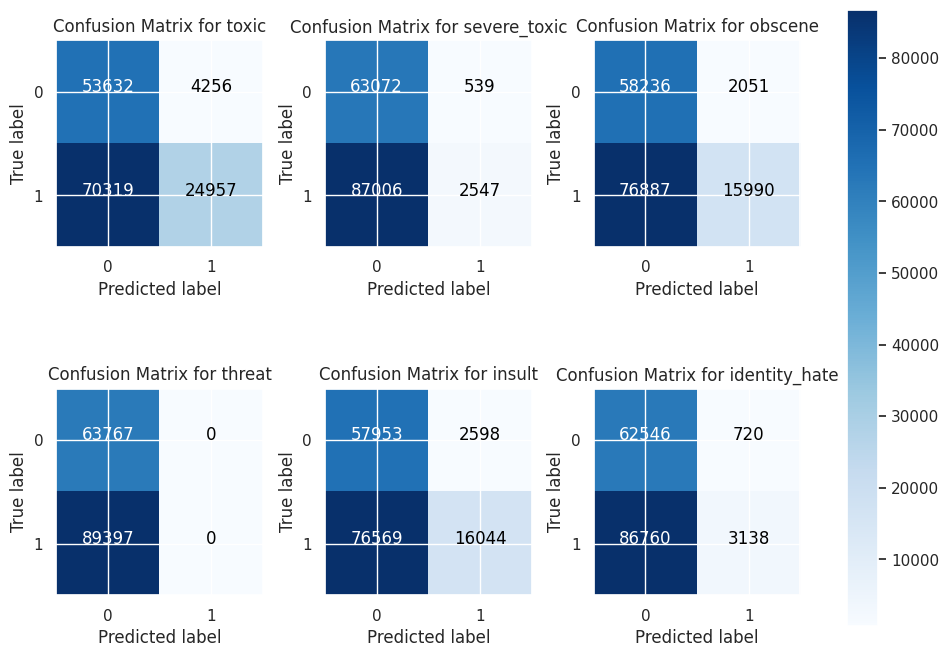

In [ ]:
# Evaluation
evaluate_model(test_labels, predictions_model_dbert)

#### Fine tuning DistilBERT without features and with LSTMs layers

In [ ]:
model_dbert_lstm = createDistilBERTmodel(includeLSTMs = True)

In [ ]:
# Summary
model_dbert_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 32, 768),                                                    
                                 hidden_states=None                                           

In [ ]:
# Training
model_dbert_lstm.fit(train_dataset, epochs=10)

Epoch 1/10
9799/9799 [==============================] - 383s 37ms/step - loss: 0.0712 - recall: 0.4874
Epoch 2/10
9799/9799 [==============================] - 374s 38ms/step - loss: 0.0578 - recall: 0.5750
Epoch 3/10
9799/9799 [==============================] - 360s 37ms/step - loss: 0.0541 - recall: 0.6039
Epoch 4/10
9799/9799 [==============================] - 358s 37ms/step - loss: 0.0516 - recall: 0.6259
Epoch 5/10
9799/9799 [==============================] - 359s 37ms/step - loss: 0.0498 - recall: 0.6412
Epoch 6/10
9799/9799 [==============================] - 360s 37ms/step - loss: 0.0480 - recall: 0.6557
Epoch 7/10
9799/9799 [==============================] - 361s 37ms/step - loss: 0.0468 - recall: 0.6624
Epoch 8/10
9799/9799 [==============================] - 353s 36ms/step - loss: 0.0454 - recall: 0.6742
Epoch 9/10
9799/9799 [==============================] - 386s 39ms/step - loss: 0.0441 - recall: 0.6827
Epoch 10/10
9799/9799 [==============================] - 362s 37ms/step -

In [ ]:
# Predictions
predictions_model_dbert_lstm = model_dbert_lstm.predict(test_dataset)

9573/9573 [==============================] - 270s 28ms/step


--------------------------------
Métricas para general: 
Accuracy: 0.3580867566791152
Recall: 0.13623561262995484
Precision: 0.8249177201477146
F1 score: 0.2137407806256141
--------------------------------
Métricas para toxic: 
Accuracy: 0.5427254446214516
Recall: 0.31974474159284605
Precision: 0.8535724292518913
F1 score: 0.4652199807583647
--------------------------------
Métricas para severe_toxic: 
Accuracy: 0.4249301402418323
Recall: 0.021104820609024823
Precision: 0.8192457737321196
F1 score: 0.041149575440888306
--------------------------------
Métricas para obscene: 
Accuracy: 0.506894570525711
Recall: 0.21636142424927593
Precision: 0.8798546346162266
F1 score: 0.347315842234436
--------------------------------
Métricas para threat: 
Accuracy: 0.41748060902039646
Recall: 0.003736143271026992
Precision: 0.6788617886178862
F1 score: 0.007431387600262546
--------------------------------
Métricas para insult: 
Accuracy: 0.5003460343161579
Recall: 0.2070011769406023
Precision: 0.861

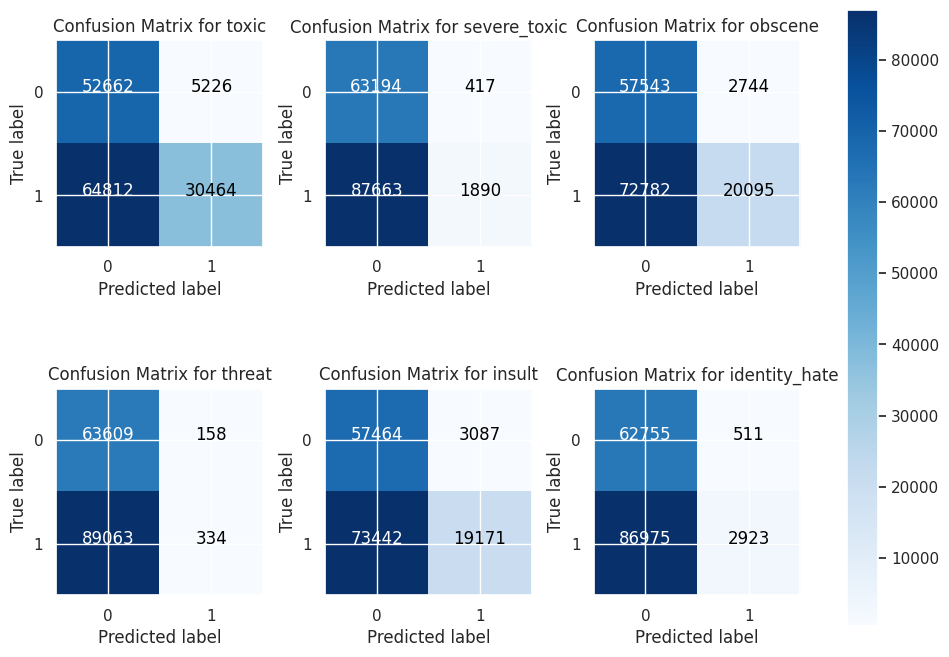

In [ ]:
# Evaluation
evaluate_model(test_labels, predictions_model_dbert_lstm)

### NN with LSTMS

In [ ]:
# Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Parameters
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

labels_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
features_list = ['comment_len', 'symbols', 'capital_letters', 'exclamation', 'question', 'cleaned_len', 'cant_words', 'swear_words', 'hate_speach']

# Train data
train_labels = df[labels_list].values
train_texts = df["cleaned_text"].values
train_features = df[features_list].values

# Test data
test_labels = df_test[labels_list].values
test_texts = df_test["cleaned_text"].values
test_features = df_test[features_list].values

In [ ]:
# Tokenizer
tokenizer = Tokenizer(oov_token=oov_tok)

tokenizer.fit_on_texts(train_texts)

In [ ]:
# Padding train data
training_sequences = tokenizer.texts_to_sequences(train_texts)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Padding test data
testing_sequences = tokenizer.texts_to_sequences(test_texts)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Parameters
embedding_dim = 32
lstm_dim = 32
dense_dim = 24

vocab_size = len(tokenizer.word_index) + 1

# LSTM model
# Text input
text_input = tf.keras.layers.Input(shape=(max_length,), name='text_input')
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(text_input)
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_layer)

# Features input
numerical_input = tf.keras.layers.Input(shape=(9,), name='numerical_input')
numerical_dense = tf.keras.layers.Dense(64, activation='relu')(numerical_input)

# Concatenate text and numerical features
concatenated = tf.keras.layers.Concatenate()([lstm_output, numerical_dense])

# Dense y dropout layers
dense_output = tf.keras.layers.Dense(32, activation='relu')(concatenated)
dense_output = tf.keras.layers.Dropout(0.2)(dense_output)
dense_output = tf.keras.layers.Dense(16, activation='relu')(dense_output)

# Final output
output = tf.keras.layers.Dense(6, activation='sigmoid')(dense_output)

# Model
model_lstm = tf.keras.models.Model(inputs=[text_input, numerical_input], outputs=output)

# Training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.Recall()])

# Model summary
model_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 32)       4338944     ['text_input[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 32, 128)     49664       ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 numerical_input (InputLayer)   [(None, 9)]          0           []                         

In [ ]:
# Training
model_lstm.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
9799/9799 [==============================] - 251s 25ms/step - loss: 0.0622 - recall_1: 0.5615
Epoch 2/10
9799/9799 [==============================] - 136s 14ms/step - loss: 0.0458 - recall_1: 0.6683
Epoch 3/10
9799/9799 [==============================] - 136s 14ms/step - loss: 0.0410 - recall_1: 0.7071
Epoch 4/10
9799/9799 [==============================] - 135s 14ms/step - loss: 0.0372 - recall_1: 0.7422
Epoch 5/10
9799/9799 [==============================] - 133s 14ms/step - loss: 0.0338 - recall_1: 0.7753
Epoch 6/10
9799/9799 [==============================] - 135s 14ms/step - loss: 0.0306 - recall_1: 0.8042
Epoch 7/10
9799/9799 [==============================] - 137s 14ms/step - loss: 0.0277 - recall_1: 0.8287
Epoch 8/10
9799/9799 [==============================] - 134s 14ms/step - loss: 0.0250 - recall_1: 0.8525
Epoch 9/10
9799/9799 [==============================] - 132s 14ms/step - loss: 0.0227 - recall_1: 0.8715
Epoch 10/10
9799/9799 [==============================] 

In [ ]:
predictions_model_lstm = model_lstm.predict([testing_padded, test_features])

4787/4787 [==============================] - 26s 5ms/step


--------------------------------
Métricas para general: 
Accuracy: 0.3117246872633256
Recall: 0.16166618754252984
Precision: 0.7619256337387251
F1 score: 0.23657707568683417
--------------------------------
Métricas para toxic: 
Accuracy: 0.5588584784936408
Recall: 0.42012678953776394
Precision: 0.7646665520469177
F1 score: 0.5423003190559736
--------------------------------
Métricas para severe_toxic: 
Accuracy: 0.4249431981405552
Recall: 0.021093654037274017
Precision: 0.8202344767694312
F1 score: 0.04112959414736109
--------------------------------
Métricas para obscene: 
Accuracy: 0.5111318586613042
Recall: 0.22848498551848143
Precision: 0.8682186400458227
F1 score: 0.3617657838883727
--------------------------------
Métricas para threat: 
Accuracy: 0.41667754824893577
Recall: 0.0021589091356533216
Precision: 0.5795795795795796
F1 score: 0.004301794271704001
--------------------------------
Métricas para insult: 
Accuracy: 0.4979694967485832
Recall: 0.23374688218716594
Precision: 0

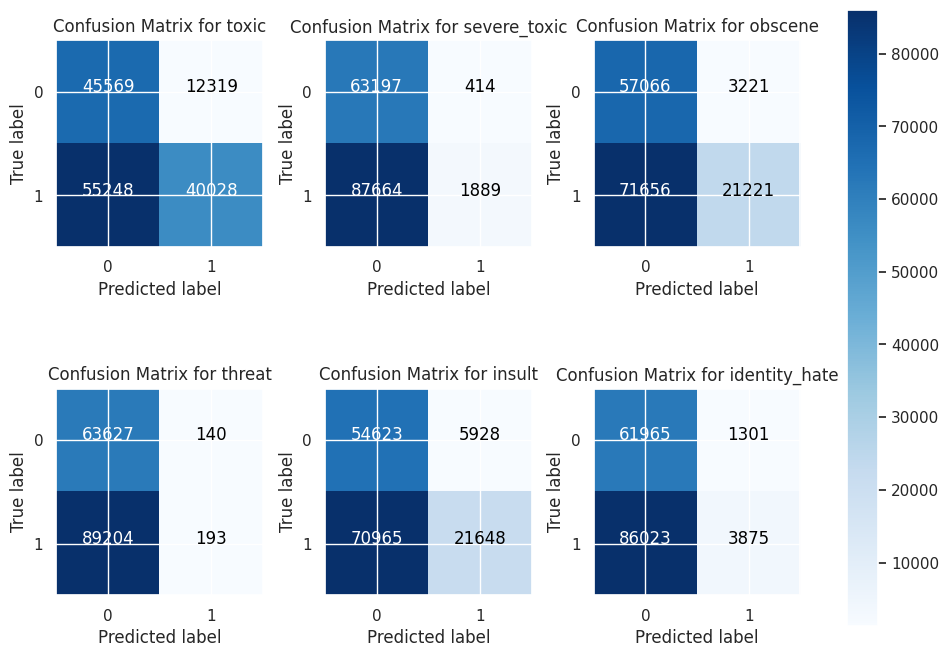

In [ ]:
# Evaluation
evaluate_model(test_labels, predictions_model_lstm)

### A model per label

#### Utils

In [ ]:
# Funtion to plot a unique confusion matrix
def plot_single_confusion_matrix(predictions, true_labels, threshold):
   # Threshold the predictions to convert them into binary labels
   binary_predictions = (predictions > threshold).astype(int)

   # Confusion matrix
   cm = confusion_matrix(true_labels, binary_predictions)

   # Plot confusion matrix
   plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
   plt.title("Confusion Matrix")
   plt.colorbar()
   tick_marks = np.arange(2)
   plt.xticks(tick_marks, [0, 1])
   plt.yticks(tick_marks, [0, 1])


   fmt = 'd'
   thresh = cm.max() / 2.
   for i in range(cm.shape[0]):
       for j in range(cm.shape[1]):
           plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


   plt.ylabel("True label")
   plt.xlabel("Predicted label")
   plt.tight_layout()

In [ ]:
labels_list = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
columns = ['id', 'comment_text', "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
features_list = ['comment_len', 'symbols', 'capital_letters', 'exclamation', 'question', 'cleaned_len', 'cant_words', 'swear_words', 'hate_speach']

In [ ]:
# Function to set the inputs to a model
def prepare_data(label, df, df2, columns, features_list):
  # Parameters
  max_length = 32
  trunc_type='post'
  padding_type='post'
  oov_tok = "<OOV>"

  columns_remove = columns.copy()
  columns_remove.remove(label)
  df_train = df.drop(columns_remove, axis=1)
  df_test = df2.drop(columns_remove, axis=1)

  # Train data
  train_labels = df_train[label].values
  train_texts = df_train["cleaned_text"].values
  train_features = df_train[features_list].values

  # Test data
  test_labels = df_test[label].values
  test_texts = df_test["cleaned_text"].values
  test_features = df_test[features_list].values

  # Initialize the Tokenizer class
  tokenizer = Tokenizer(oov_token=oov_tok)

  # Generate the word index dictionary
  tokenizer.fit_on_texts(train_texts)

  # Generate and pad the training sequences
  training_sequences = tokenizer.texts_to_sequences(train_texts)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  # Generate and pad the testing sequences
  testing_sequences = tokenizer.texts_to_sequences(test_texts)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  vocab_size = len(tokenizer.word_index) + 1

  return training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size

In [ ]:
# Function to create a model
def create_model(vocab_size, max_length=32, embedding_dim = 32, lstm_dim = 64, dense_dim = 32, n_features=9, metric='accuracy', include_features=False):
  # Text input
  text_input = tf.keras.layers.Input(shape=(max_length,), name='text_input')

  embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)(text_input)
  lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True))(embedding_layer)
  output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim))(lstm_layer)

  if(include_features):
    # Features input
    numerical_input = tf.keras.layers.Input(shape=(n_features,), name='numerical_input')
    numerical_dense = tf.keras.layers.Dense(dense_dim, activation='relu')(numerical_input)
    # Concateno texto y features
    output = tf.keras.layers.Concatenate()([output, numerical_dense])

  # Dense and dropout layers
  dense_output = tf.keras.layers.Dense(dense_dim, activation='relu')(output)
  dense_output = tf.keras.layers.Dropout(0.2)(dense_output)
  dense_output = tf.keras.layers.Dense(dense_dim/2, activation='relu')(dense_output)

  # Final output
  output = tf.keras.layers.Dense(1, activation='sigmoid')(dense_output)

  # Model
  if(include_features):
    model = tf.keras.models.Model(inputs=[text_input, numerical_input], outputs=output)
  else:
    model = tf.keras.models.Model(inputs=text_input, outputs=output)

  if (metric == 'recall'):
    metric = tf.keras.metrics.Recall()

  # Set the training parameters
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[metric])

  return model


In [ ]:
# Defino threshold
threshold = 0.3

#### Toxic model

In [ ]:
# Set inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('toxic', df_toxic_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_toxic_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_toxic_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
1870/1870 [==============================] - 82s 36ms/step - loss: 0.2923 - recall: 0.8630
Epoch 2/10
1870/1870 [==============================] - 28s 15ms/step - loss: 0.1565 - recall: 0.9459
Epoch 3/10
1870/1870 [==============================] - 27s 14ms/step - loss: 0.1009 - recall: 0.9683
Epoch 4/10
1870/1870 [==============================] - 26s 14ms/step - loss: 0.0656 - recall: 0.9788
Epoch 5/10
1870/1870 [==============================] - 24s 13ms/step - loss: 0.0425 - recall: 0.9872
Epoch 6/10
1870/1870 [==============================] - 25s 13ms/step - loss: 0.0283 - recall: 0.9904
Epoch 7/10
1870/1870 [==============================] - 25s 13ms/step - loss: 0.0222 - recall: 0.9918
Epoch 8/10
1870/1870 [==============================] - 25s 13ms/step - loss: 0.0176 - recall: 0.9939
Epoch 9/10
1870/1870 [==============================] - 24s 13ms/step - loss: 0.0124 - recall: 0.9961
Epoch 10/10
1870/1870 [==============================] - 25s 13ms/step - loss: 0.0

In [ ]:
# Evaluate model
predictions_toxic_f = model_toxic_features.predict([testing_padded, test_features])
binary_predictions = (predictions_toxic_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='toxic')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para toxic: 
Accuracy: 0.5640881669321772
Recall: 0.42753684033754563
Precision: 0.7691755730956608
F1 score: 0.5495905122981233


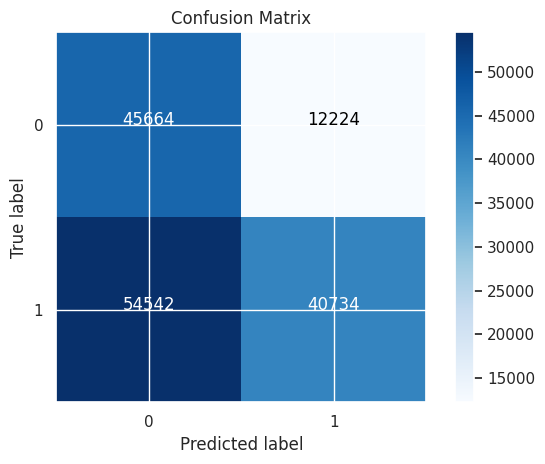

In [ ]:
# Confusion matrix
plot_single_confusion_matrix(predictions_toxic_f, test_labels, threshold)

##### Model with no features

In [ ]:
# Model with no features
model_toxic = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_toxic.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1870/1870 [==============================] - 87s 37ms/step - loss: 0.2986 - recall_1: 0.8690
Epoch 2/10
1870/1870 [==============================] - 38s 20ms/step - loss: 0.1627 - recall_1: 0.9414
Epoch 3/10
1870/1870 [==============================] - 30s 16ms/step - loss: 0.1050 - recall_1: 0.9649
Epoch 4/10
1870/1870 [==============================] - 28s 15ms/step - loss: 0.0726 - recall_1: 0.9776
Epoch 5/10
1870/1870 [==============================] - 35s 19ms/step - loss: 0.0477 - recall_1: 0.9848
Epoch 6/10
1870/1870 [==============================] - 26s 14ms/step - loss: 0.0319 - recall_1: 0.9884
Epoch 7/10
1870/1870 [==============================] - 41s 22ms/step - loss: 0.0233 - recall_1: 0.9919
Epoch 8/10
1870/1870 [==============================] - 32s 17ms/step - loss: 0.0182 - recall_1: 0.9949
Epoch 9/10
1870/1870 [==============================] - 25s 13ms/step - loss: 0.0144 - recall_1: 0.9955
Epoch 10/10
1870/1870 [==============================] - 37s 20m

In [ ]:
# Evaluate model
predictions_toxic = model_toxic.predict(testing_padded)
binary_predictions = (predictions_toxic > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='toxic')

4787/4787 [==============================] - 24s 5ms/step
--------------------------------
Métricas para toxic: 
Accuracy: 0.5654918910448931
Recall: 0.4428712372475755
Precision: 0.7580167070870385
F1 score: 0.5590926255954314


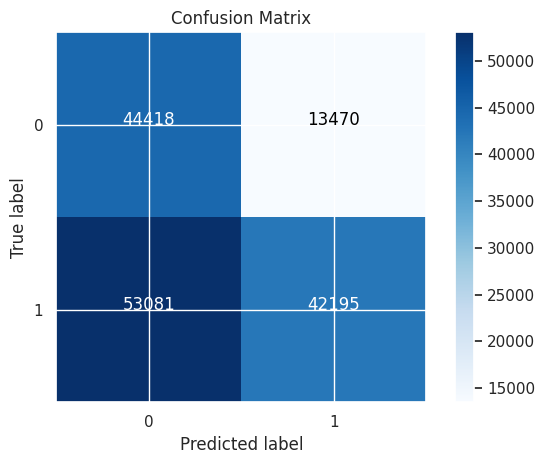

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_toxic, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_toxic_final = model_toxic

In [ ]:
model_toxic_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 32)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 32, 32)            1467328   
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 128)          49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0   

#### Severe toxic model

In [ ]:
# Set inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('severe_toxic', df_severe_toxic_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_severe_toxic_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_severe_toxic_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
192/192 [==============================] - 37s 141ms/step - loss: 0.3290 - recall_4: 0.8824
Epoch 2/10
192/192 [==============================] - 10s 53ms/step - loss: 0.0973 - recall_4: 0.9869
Epoch 3/10
192/192 [==============================] - 7s 39ms/step - loss: 0.0512 - recall_4: 0.9948
Epoch 4/10
192/192 [==============================] - 4s 20ms/step - loss: 0.0388 - recall_4: 0.9954
Epoch 5/10
192/192 [==============================] - 3s 16ms/step - loss: 0.0375 - recall_4: 0.9941
Epoch 6/10
192/192 [==============================] - 5s 27ms/step - loss: 0.0229 - recall_4: 0.9941
Epoch 7/10
192/192 [==============================] - 3s 16ms/step - loss: 0.0129 - recall_4: 0.9967
Epoch 8/10
192/192 [==============================] - 3s 14ms/step - loss: 0.0180 - recall_4: 0.9954
Epoch 9/10
192/192 [==============================] - 4s 19ms/step - loss: 0.0063 - recall_4: 0.9987
Epoch 10/10
192/192 [==============================] - 3s 18ms/step - loss: 0.0016 - rec

In [ ]:
# Evaluate the model
predictions_severe_toxic_f = model_severe_toxic_features.predict([testing_padded, test_features])
binary_predictions = (predictions_severe_toxic_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='severe_toxic')

4787/4787 [==============================] - 26s 5ms/step
--------------------------------
Métricas para severe_toxic: 
Accuracy: 0.4943851035491369
Recall: 0.24873538574922113
Precision: 0.6866734486266531
F1 score: 0.36518788117253587


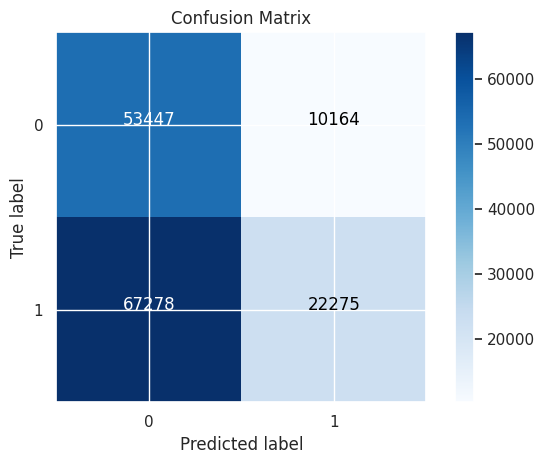

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_severe_toxic_f, test_labels, threshold=0.3)

##### Model with no features

In [ ]:
# Model with no features
model_severe_toxic = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_severe_toxic.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
192/192 [==============================] - 28s 107ms/step - loss: 0.3507 - recall_5: 0.8804
Epoch 2/10
192/192 [==============================] - 7s 39ms/step - loss: 0.0984 - recall_5: 0.9804
Epoch 3/10
192/192 [==============================] - 5s 28ms/step - loss: 0.0533 - recall_5: 0.9941
Epoch 4/10
192/192 [==============================] - 5s 26ms/step - loss: 0.0327 - recall_5: 0.9961
Epoch 5/10
192/192 [==============================] - 3s 17ms/step - loss: 0.0269 - recall_5: 0.9980
Epoch 6/10
192/192 [==============================] - 3s 18ms/step - loss: 0.0115 - recall_5: 0.9980
Epoch 7/10
192/192 [==============================] - 4s 20ms/step - loss: 0.0056 - recall_5: 0.9993
Epoch 8/10
192/192 [==============================] - 3s 18ms/step - loss: 0.0197 - recall_5: 0.9967
Epoch 9/10
192/192 [==============================] - 3s 16ms/step - loss: 0.0038 - recall_5: 0.9993
Epoch 10/10
192/192 [==============================] - 2s 12ms/step - loss: 0.0139 - reca

In [ ]:
# Evaluate the model
predictions_severe_toxic = model_severe_toxic.predict(testing_padded)
binary_predictions = (predictions_severe_toxic > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='severe_toxic')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para severe_toxic: 
Accuracy: 0.4931837768666266
Recall: 0.23761348028541757
Precision: 0.6946883875812085
F1 score: 0.3541070358783199


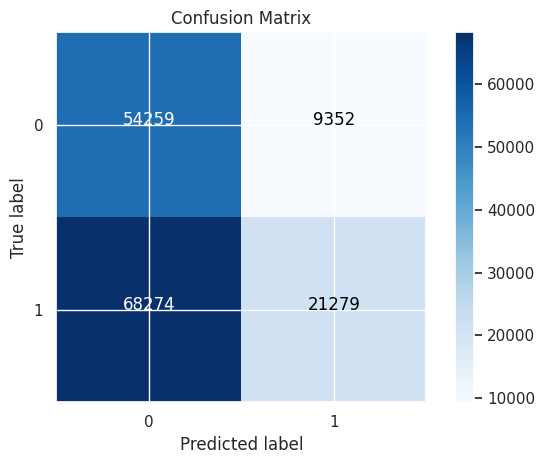

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_severe_toxic, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_severe_toxic_final = model_severe_toxic_features

In [ ]:
model_severe_toxic_final.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 32)       346752      ['text_input[0][0]']             
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 32, 128)     49664       ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 numerical_input (InputLayer)   [(None, 9)]          0           []                         

#### Obscene model

In [ ]:
# Model inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('obscene', df_obscene_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_obscene_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_obscene_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
1029/1029 [==============================] - 63s 53ms/step - loss: 0.2459 - recall_6: 0.8858
Epoch 2/10
1029/1029 [==============================] - 15s 15ms/step - loss: 0.0935 - recall_6: 0.9752
Epoch 3/10
1029/1029 [==============================] - 19s 19ms/step - loss: 0.0523 - recall_6: 0.9908
Epoch 4/10
1029/1029 [==============================] - 17s 16ms/step - loss: 0.0344 - recall_6: 0.9934
Epoch 5/10
1029/1029 [==============================] - 13s 13ms/step - loss: 0.0222 - recall_6: 0.9945
Epoch 6/10
1029/1029 [==============================] - 13s 13ms/step - loss: 0.0151 - recall_6: 0.9967
Epoch 7/10
1029/1029 [==============================] - 13s 12ms/step - loss: 0.0107 - recall_6: 0.9972
Epoch 8/10
1029/1029 [==============================] - 12s 12ms/step - loss: 0.0075 - recall_6: 0.9985
Epoch 9/10
1029/1029 [==============================] - 13s 12ms/step - loss: 0.0095 - recall_6: 0.9976
Epoch 10/10
1029/1029 [==============================] - 12s 12m

In [ ]:
# Evaluate the model
predictions_obscene_f = model_obscene_features.predict([testing_padded, test_features])
binary_predictions = (predictions_obscene_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='obscene')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para obscene: 
Accuracy: 0.5314956517197252
Recall: 0.30901084229680115
Precision: 0.7910476557978005
F1 score: 0.44441691571563513


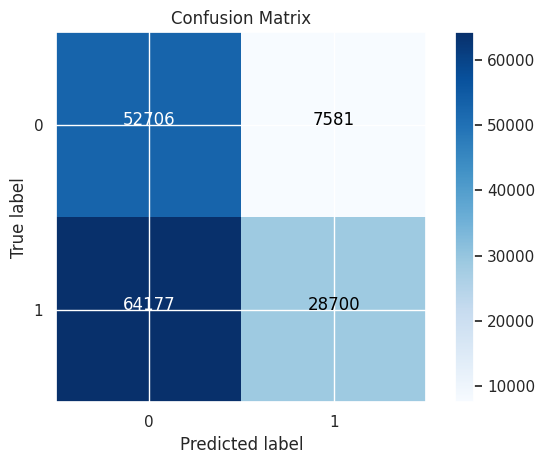

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_obscene_f, test_labels, threshold=0.3)

##### Modelo with no features

In [ ]:
# Modelo with no features
model_obscene = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_obscene.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
1029/1029 [==============================] - 50s 41ms/step - loss: 0.2670 - recall_7: 0.8955
Epoch 2/10
1029/1029 [==============================] - 16s 15ms/step - loss: 0.1163 - recall_7: 0.9671
Epoch 3/10
1029/1029 [==============================] - 13s 12ms/step - loss: 0.0687 - recall_7: 0.9804
Epoch 4/10
1029/1029 [==============================] - 14s 13ms/step - loss: 0.0418 - recall_7: 0.9911
Epoch 5/10
1029/1029 [==============================] - 13s 13ms/step - loss: 0.0284 - recall_7: 0.9938
Epoch 6/10
1029/1029 [==============================] - 12s 12ms/step - loss: 0.0214 - recall_7: 0.9949
Epoch 7/10
1029/1029 [==============================] - 12s 12ms/step - loss: 0.0161 - recall_7: 0.9970
Epoch 8/10
1029/1029 [==============================] - 12s 12ms/step - loss: 0.0152 - recall_7: 0.9965
Epoch 9/10
1029/1029 [==============================] - 12s 11ms/step - loss: 0.0089 - recall_7: 0.9973
Epoch 10/10
1029/1029 [==============================] - 12s 11m

In [ ]:
# Evaluate the model
predictions_obscene = model_obscene.predict(testing_padded)
binary_predictions = (predictions_obscene > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='obscene')

4787/4787 [==============================] - 24s 5ms/step
--------------------------------
Métricas para obscene: 
Accuracy: 0.5277349768875192
Recall: 0.29708108573705005
Precision: 0.7965128027481886
F1 score: 0.4327545915086498


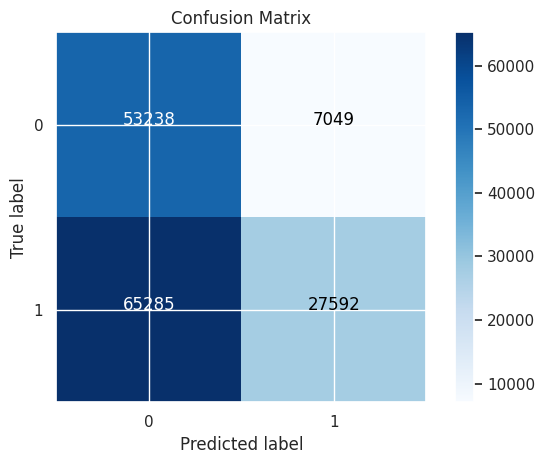

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_obscene, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_obscene_final = model_obscene_features

In [ ]:
model_obscene_final.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 32, 32)       990976      ['text_input[0][0]']             
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 32, 128)     49664       ['embedding_6[0][0]']            
 l)                                                                                               
                                                                                                  
 numerical_input (InputLayer)   [(None, 9)]          0           []                         

#### Threat model

In [ ]:
# Model inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('threat', df_threat_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_threat_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_threat_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
58/58 [==============================] - 20s 197ms/step - loss: 0.6419 - recall_8: 0.5565
Epoch 2/10
58/58 [==============================] - 7s 124ms/step - loss: 0.2586 - recall_8: 0.9326
Epoch 3/10
58/58 [==============================] - 5s 89ms/step - loss: 0.0732 - recall_8: 0.9804
Epoch 4/10
58/58 [==============================] - 4s 66ms/step - loss: 0.0337 - recall_8: 0.9957
Epoch 5/10
58/58 [==============================] - 5s 86ms/step - loss: 0.0243 - recall_8: 0.9957
Epoch 6/10
58/58 [==============================] - 2s 36ms/step - loss: 0.0082 - recall_8: 0.9978
Epoch 7/10
58/58 [==============================] - 2s 36ms/step - loss: 0.0022 - recall_8: 1.0000
Epoch 8/10
58/58 [==============================] - 1s 26ms/step - loss: 0.0012 - recall_8: 1.0000
Epoch 9/10
58/58 [==============================] - 1s 22ms/step - loss: 3.5397e-04 - recall_8: 1.0000
Epoch 10/10
58/58 [==============================] - 2s 32ms/step - loss: 1.8233e-04 - recall_8: 1.000

In [ ]:
# Evaluate the model
predictions_threat_f = model_threat_features.predict([testing_padded, test_features])
binary_predictions = (predictions_threat_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='threat')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para threat: 
Accuracy: 0.4789898409547936
Recall: 0.21809456693177623
Precision: 0.6632309419328503
F1 score: 0.3282489014596697


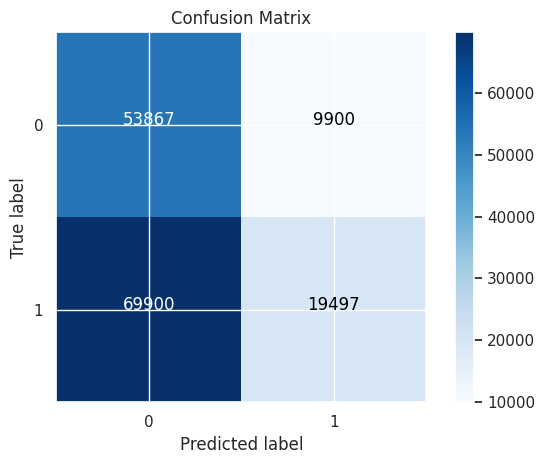

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_threat_f, test_labels, threshold=0.3)

##### Model with no features

In [ ]:
# Model with no features
model_threat = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_threat.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
58/58 [==============================] - 17s 159ms/step - loss: 0.6592 - recall_9: 0.5717
Epoch 2/10
58/58 [==============================] - 4s 67ms/step - loss: 0.3703 - recall_9: 0.8435
Epoch 3/10
58/58 [==============================] - 6s 104ms/step - loss: 0.1423 - recall_9: 0.9522
Epoch 4/10
58/58 [==============================] - 3s 50ms/step - loss: 0.0559 - recall_9: 0.9826
Epoch 5/10
58/58 [==============================] - 3s 46ms/step - loss: 0.0413 - recall_9: 0.9913
Epoch 6/10
58/58 [==============================] - 1s 22ms/step - loss: 0.0217 - recall_9: 0.9957
Epoch 7/10
58/58 [==============================] - 1s 19ms/step - loss: 0.0440 - recall_9: 0.9978
Epoch 8/10
58/58 [==============================] - 2s 27ms/step - loss: 0.0255 - recall_9: 0.9978
Epoch 9/10
58/58 [==============================] - 2s 32ms/step - loss: 0.0135 - recall_9: 0.9978
Epoch 10/10
58/58 [==============================] - 2s 43ms/step - loss: 0.0256 - recall_9: 0.9978


In [ ]:
# Evaluate the model
predictions_threat = model_threat.predict(testing_padded)
binary_predictions = (predictions_threat > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='threat')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para threat: 
Accuracy: 0.46939881434279596
Recall: 0.19217647124623868
Precision: 0.6549252820982007
F1 score: 0.2971572875316746


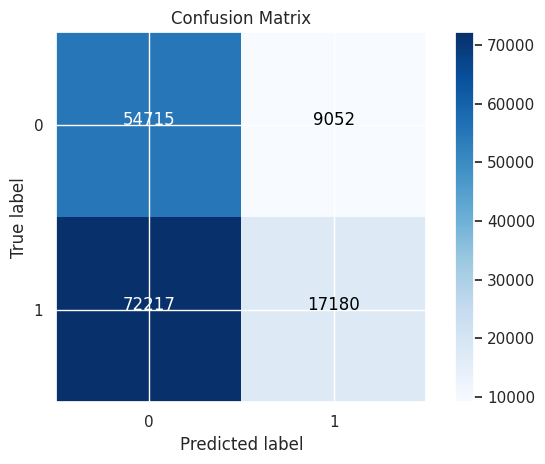

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_threat, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_threat_final = model_threat

#### Insult model

In [ ]:
# Model inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('insult', df_insult_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_insult_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_insult_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
961/961 [==============================] - 62s 56ms/step - loss: 0.2924 - recall_10: 0.8710
Epoch 2/10
961/961 [==============================] - 18s 19ms/step - loss: 0.1307 - recall_10: 0.9659
Epoch 3/10
961/961 [==============================] - 14s 15ms/step - loss: 0.0813 - recall_10: 0.9850
Epoch 4/10
961/961 [==============================] - 15s 15ms/step - loss: 0.0511 - recall_10: 0.9915
Epoch 5/10
961/961 [==============================] - 15s 16ms/step - loss: 0.0395 - recall_10: 0.9927
Epoch 6/10
961/961 [==============================] - 13s 14ms/step - loss: 0.0270 - recall_10: 0.9949
Epoch 7/10
961/961 [==============================] - 14s 15ms/step - loss: 0.0208 - recall_10: 0.9967
Epoch 8/10
961/961 [==============================] - 13s 14ms/step - loss: 0.0157 - recall_10: 0.9970
Epoch 9/10
961/961 [==============================] - 13s 13ms/step - loss: 0.0136 - recall_10: 0.9971
Epoch 10/10
961/961 [==============================] - 12s 13ms/step - lo

In [ ]:
# Evaluate the model
predictions_insult_f = model_insult_features.predict([testing_padded, test_features])
binary_predictions = (predictions_insult_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='insult')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para insult: 
Accuracy: 0.5240004178527591
Recall: 0.2985541986546165
Precision: 0.7768381423313573
F1 score: 0.431337066907945


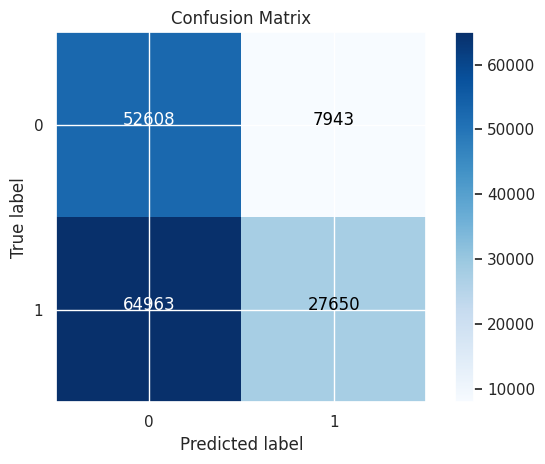

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_insult_f, test_labels, threshold=0.3)

##### Model with no features

In [ ]:
# Model with no features
model_insult = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_insult.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
961/961 [==============================] - 51s 45ms/step - loss: 0.3037 - recall_11: 0.8801
Epoch 2/10
961/961 [==============================] - 17s 18ms/step - loss: 0.1393 - recall_11: 0.9615
Epoch 3/10
961/961 [==============================] - 14s 15ms/step - loss: 0.0856 - recall_11: 0.9826
Epoch 4/10
961/961 [==============================] - 14s 14ms/step - loss: 0.0607 - recall_11: 0.9888
Epoch 5/10
961/961 [==============================] - 13s 13ms/step - loss: 0.0503 - recall_11: 0.9896
Epoch 6/10
961/961 [==============================] - 13s 13ms/step - loss: 0.0346 - recall_11: 0.9944
Epoch 7/10
961/961 [==============================] - 13s 13ms/step - loss: 0.0309 - recall_11: 0.9948
Epoch 8/10
961/961 [==============================] - 13s 13ms/step - loss: 0.0213 - recall_11: 0.9966
Epoch 9/10
961/961 [==============================] - 12s 13ms/step - loss: 0.0185 - recall_11: 0.9965
Epoch 10/10
961/961 [==============================] - 12s 13ms/step - lo

In [ ]:
# Evaluate the model
predictions_insult = model_insult.predict(testing_padded)
binary_predictions = (predictions_insult > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='insult')

4787/4787 [==============================] - 24s 5ms/step
--------------------------------
Métricas para insult: 
Accuracy: 0.5406884124206732
Recall: 0.37925561206310127
Precision: 0.7319787433572992
F1 score: 0.4996372636879614


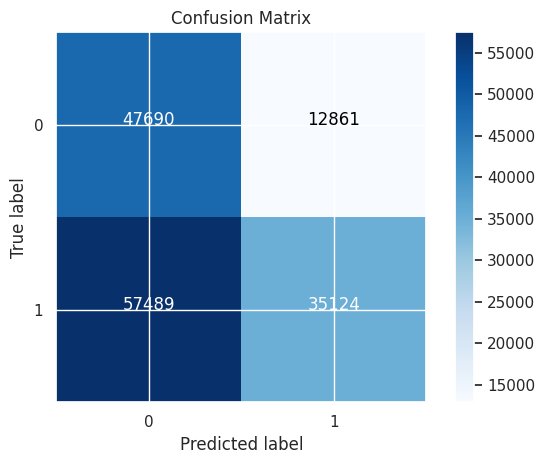

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_insult, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_insult_final = model_insult

#### Identity hate model

In [ ]:
# Model inputs
training_padded, train_labels, train_features, testing_padded, test_labels, test_features, vocab_size = prepare_data('identity_hate', df_identity_hate_completo, df_test, columns, features_list)

##### Model with features

In [ ]:
# Model with features
model_identity_hate_features = create_model(vocab_size, metric='recall', include_features=True)

In [ ]:
# Train the model
model_identity_hate_features.fit([training_padded, train_features], train_labels, epochs=10, batch_size=16)

Epoch 1/10
172/172 [==============================] - 36s 151ms/step - loss: 0.4802 - recall_12: 0.7369
Epoch 2/10
172/172 [==============================] - 11s 61ms/step - loss: 0.1538 - recall_12: 0.9643
Epoch 3/10
172/172 [==============================] - 5s 28ms/step - loss: 0.0724 - recall_12: 0.9847
Epoch 4/10
172/172 [==============================] - 5s 28ms/step - loss: 0.0376 - recall_12: 0.9956
Epoch 5/10
172/172 [==============================] - 5s 27ms/step - loss: 0.0315 - recall_12: 0.9949
Epoch 6/10
172/172 [==============================] - 3s 16ms/step - loss: 0.0434 - recall_12: 0.9905
Epoch 7/10
172/172 [==============================] - 3s 16ms/step - loss: 0.0170 - recall_12: 0.9971
Epoch 8/10
172/172 [==============================] - 3s 16ms/step - loss: 0.0115 - recall_12: 0.9985
Epoch 9/10
172/172 [==============================] - 4s 26ms/step - loss: 0.0070 - recall_12: 1.0000
Epoch 10/10
172/172 [==============================] - 3s 15ms/step - loss: 0.0

In [ ]:
# Evaluate the model
predictions_identity_hate_f = model_identity_hate_features.predict([testing_padded, test_features])
binary_predictions = (predictions_identity_hate_f > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='identity_hate')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para identity_hate: 
Accuracy: 0.4838734950771722
Recall: 0.2218736790584885
Precision: 0.6867038490669972
F1 score: 0.3353847188592951


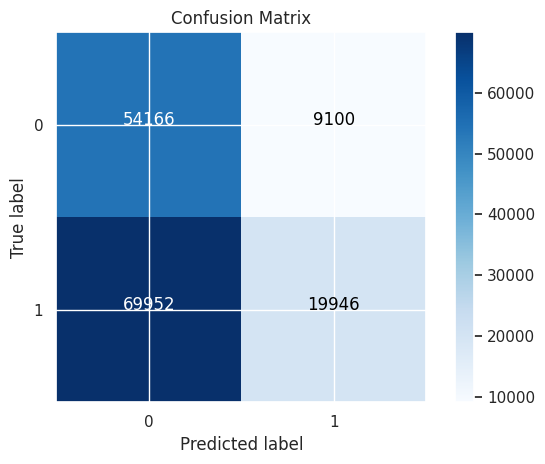

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_identity_hate_f, test_labels, threshold=0.3)

##### Model with no features

In [ ]:
# Model with no features
model_identity_hate = create_model(vocab_size, metric='recall')

In [ ]:
# Train the model
model_identity_hate.fit(training_padded, train_labels, epochs=10, batch_size=16)

Epoch 1/10
172/172 [==============================] - 28s 108ms/step - loss: 0.4576 - recall_13: 0.7507
Epoch 2/10
172/172 [==============================] - 8s 47ms/step - loss: 0.1417 - recall_13: 0.9687
Epoch 3/10
172/172 [==============================] - 5s 27ms/step - loss: 0.0637 - recall_13: 0.9898
Epoch 4/10
172/172 [==============================] - 4s 24ms/step - loss: 0.0513 - recall_13: 0.9920
Epoch 5/10
172/172 [==============================] - 3s 17ms/step - loss: 0.0315 - recall_13: 0.9971
Epoch 6/10
172/172 [==============================] - 3s 19ms/step - loss: 0.0165 - recall_13: 1.0000
Epoch 7/10
172/172 [==============================] - 3s 19ms/step - loss: 0.0159 - recall_13: 0.9993
Epoch 8/10
172/172 [==============================] - 3s 19ms/step - loss: 0.0254 - recall_13: 0.9913
Epoch 9/10
172/172 [==============================] - 4s 23ms/step - loss: 0.0292 - recall_13: 0.9956
Epoch 10/10
172/172 [==============================] - 3s 16ms/step - loss: 0.05

In [ ]:
# Evaluate the model
predictions_identity_hate = model_identity_hate.predict(testing_padded)
binary_predictions = (predictions_identity_hate > threshold).astype(int)
calculate_metrics(binary_predictions, test_labels, average='binary', label='identity_hate')

4787/4787 [==============================] - 25s 5ms/step
--------------------------------
Métricas para identity_hate: 
Accuracy: 0.47547726619832337
Recall: 0.20784667067120513
Precision: 0.6718806184825602
F1 score: 0.3174805450776497


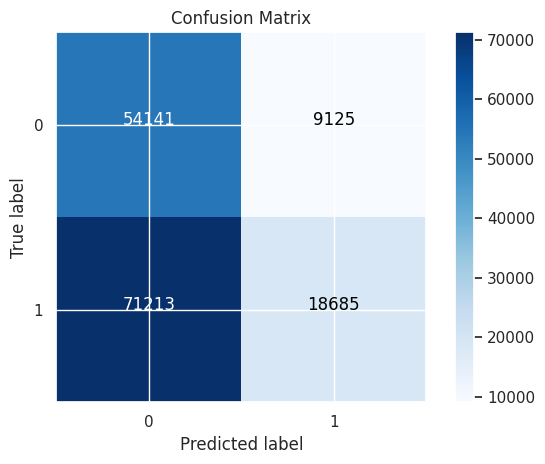

In [ ]:
# Confusion matrix
plot_confusion_matrix(predictions_identity_hate, test_labels, threshold=0.3)

##### Final model

In [ ]:
# Final model
model_identity_hate_final = model_identity_hate_features

### File with final results

In [ ]:
# Final df with the ids of the test dataset
resultados = df_test[['id']]

# Add predictions
resultados['toxic'] = predictions_toxic
resultados['severe_toxic'] = predictions_severe_toxic_f
resultados['obscene'] = predictions_obscene_f
resultados['threat'] = predictions_threat_f
resultados['insult'] = predictions_insult
resultados['identity_hate'] = predictions_identity_hate_f

<ipython-input-154-81ef9e758923>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['toxic'] = predictions_toxic
<ipython-input-154-81ef9e758923>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['severe_toxic'] = predictions_severe_toxic_f
<ipython-input-154-81ef9e758923>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# Set index
resultados = resultados.set_index('id')

In [ ]:
resultados

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,1.000000,0.999932,1.000000e+00,0.999973,9.995390e-01,0.999704
0000247867823ef7,0.000038,0.000009,5.039877e-06,0.000023,6.136268e-04,0.000004
00013b17ad220c46,0.026669,0.000234,1.980747e-05,0.000016,9.369451e-05,0.000005
00017563c3f7919a,0.000052,0.000021,2.959209e-09,0.000028,5.557731e-06,0.000008
00017695ad8997eb,0.000245,0.000013,1.306601e-05,0.000031,2.877440e-05,0.000008
...,...,...,...,...,...,...
fffcd0960ee309b5,0.021468,0.000012,9.992570e-01,0.000025,1.263260e-01,0.000015
fffd7a9a6eb32c16,0.035385,0.000011,6.430320e-01,0.999863,7.796822e-07,0.999170
fffda9e8d6fafa9e,0.000016,0.000007,1.970417e-08,0.000014,5.835525e-06,0.000006


In [ ]:
# Save final results
resultados.to_csv('resultados.csv')